# Agregación y agrupación

Una parte esencial del análisis de grandes cantidades de datos es la sumarización eficiente; la capacidad de hacer operaciones tales como ``sum()``, ``mean()``, ``median()``, ``min()``, and ``max()`` dónde un sólo número da visión de la naturaleza de una gran cantidad de datos. En este capítulo  vamos a explorar las agregaciones que nos ofrece Pandas, desde las más simple, que ya hemos visto y trabajado con los Numpy Arrays, a los más sofisticados basados en el concepto de ``GroupBy``.

In [1]:
import numpy as np
import pandas as pd

### Vamos a usar el objeto ``display()`` para visualizar las salidas de información de manera más clara:

In [85]:
class display(object):
    """Representador HTML de múltiples objetos"""

    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)
    
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                           for a in self.args)

## Dataset de planetas

Para explicar las bases, vamos a usar el **Dataset** de Planets, disponible con el paquete de ``Seaborn``, que ya descubriremos en el módulo de visualización. Da información de los planetas que los astrónomos han descubierto orbitando en otras estrellas (conocidos como *planetas extrasolares* o *exoplanetas*). Puede ser descargado con un comando de la librería ``Seaborn``

In [86]:
import seaborn as sns

planets = sns.load_dataset('planets')
planets.shape

(1035, 6)

In [87]:
planets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1035 entries, 0 to 1034
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   method          1035 non-null   object 
 1   number          1035 non-null   int64  
 2   orbital_period  992 non-null    float64
 3   mass            513 non-null    float64
 4   distance        808 non-null    float64
 5   year            1035 non-null   int64  
dtypes: float64(3), int64(2), object(1)
memory usage: 48.6+ KB


In [5]:
planets.head(10)

,method,number,orbital_period,mass,distance,year
0,Radial Velocity,1,269.300,7.10,77.40,2006
1,Radial Velocity,1,874.774,2.21,56.95,2008
2,Radial Velocity,1,763.000,2.60,19.84,2011
3,Radial Velocity,1,326.030,19.40,110.62,2007
4,Radial Velocity,1,516.220,10.50,119.47,2009
5,Radial Velocity,1,185.840,4.80,76.39,2008
6,Radial Velocity,1,1773.400,4.64,18.15,2002
7,Radial Velocity,1,798.500,NaN,21.41,1996
8,Radial Velocity,1,993.300,10.30,73.10,2008
9,Radial Velocity,2,452.800,1.99,74.79,2010


Estos son algunos de los detalles en los planetas descubiertos hasta 2014 (unos 1035)

## Agregación básica en Pandas

Anteriormente, ya hemos visto algunas de las funciones de agregación que teníamos en Numpy em Numpy I. Con un sólo nivel dimensional, la agregación funciona así para una ``Series``:

In [6]:
rng = np.random.RandomState(42)
ser = pd.Series(rng.rand(5))
ser

0    0.374540
1    0.950714
2    0.731994
3    0.598658
4    0.156019
dtype: float64

In [7]:
ser.sum()

2.811925491708157

In [8]:
ser.mean()

0.5623850983416314

### Para un ``Dataframe``, la agregación devuelve un resultado **para cada columna**:

In [9]:
df = pd.DataFrame({'A': rng.rand(5),
                   'B': rng.rand(5)})
df

,A,B
0,0.155995,0.020584
1,0.058084,0.969910
2,0.866176,0.832443
3,0.601115,0.212339
4,0.708073,0.181825


In [10]:
df.mean()

A    0.477888
B    0.443420
dtype: float64

Si así lo disponemos con el argumento ``axis``, podemos agregar **en cada fila**:

In [11]:
df.mean(axis='columns')

0    0.088290
1    0.513997
2    0.849309
3    0.406727
4    0.444949
dtype: float64

Las ``Series`` y ``Dataframe`` de Pandas incluye todos los tipos de agregaciones que hemos visto ya para los Numpy Arrays, pero además, tenemos el método ``describe()`` que computa distintos agregaciones estándar para cada columna para darnos información clave:

In [12]:
planets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1035 entries, 0 to 1034
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   method          1035 non-null   object 
 1   number          1035 non-null   int64  
 2   orbital_period  992 non-null    float64
 3   mass            513 non-null    float64
 4   distance        808 non-null    float64
 5   year            1035 non-null   int64  
dtypes: float64(3), int64(2), object(1)
memory usage: 48.6+ KB


In [13]:
planets.dropna().describe()

,number,orbital_period,mass,distance,year
count,498.00000,498.000000,498.000000,498.000000,498.000000
mean,1.73494,835.778671,2.509320,52.068213,2007.377510
std,1.17572,1469.128259,3.636274,46.596041,4.167284
min,1.00000,1.328300,0.003600,1.350000,1989.000000
25%,1.00000,38.272250,0.212500,24.497500,2005.000000
50%,1.00000,357.000000,1.245000,39.940000,2009.000000
75%,2.00000,999.600000,2.867500,59.332500,2011.000000
max,6.00000,17337.500000,25.000000,354.000000,2014.000000


Esto es muy útil para comenzar a entender de manera general las propiedades del Dataset. Por ejemplo, sabemos por la columna ``year`` que el primer exoplaneta fue descubierto en 1989, y que la mitad de ellos no habían sido descubiertos antes del año 2009. Esto es gracias a la misión *Kepler*, que es un telescopio espacial que está específicamente para buscar planetas que eclipsan a otras estrellas. 

Las siguientes agregaciones vienen con el paquete de Pandas:

| Agregación              | Descripción                     |
|--------------------------|---------------------------------|
| ``count()``              | Número total de elementos          |
| ``first()``, ``last()``  | Primer y último elemento             |
| ``mean()``, ``median()`` | Media y mediana                 |
| ``min()``, ``max()``     | Mínimo y máximo             |
| ``std()``, ``var()``     | Desviación estándar y varianza |
| ``mad()``                | Desviación media absoluta         |
| ``prod()``               | Producto de todos los elementos            |
| ``sum()``                | Suma de todos los elementos               |

Todos están presentes como objetos de ``Dataframe`` y ``Series``.

Para ir más allá de los datos estas agregaciones no son suficiente. El siguiente nivel de sumarización es el conocido ``groupby``, que nos permite procesar subsets de datos de manera rápida y eficiente.

## GroupBy: Split, Apply, Combine

Agregaciones más simples nos permiten saborear el dataset, pero casi siempre preferiremos agregar condicionalmente en algún o algunas dimensiones/índices: esto se implementa con la operación ``groupby``.

El nombre de *Group By* viene de un comando de **SQL**, pero quizás es más explicativo verlo por el término que describió Hadley Wickham de RStats: *split, apply, combine*.

### Split, apply, combine

Un ejemplo muy canónico de este término *split-apply-combine* es el de agregar en forma de suma.

Esto nos ayuda a aclarar lo que ``groupby`` realiza:

- El paso de **split/separar** involucra romper y agrupar el ``Dataframe`` dependiento del valor de una clave especificada.
- El paso de **apply/aplicar** involucra computar alguna función, usualmente una agregación, una transformación, un filtrado entre esos grupos individuales.
- El paso de **combine/combinar** une esos resultados en un array de salida/output

Mientras esto podría ser realizado de manera manual usando una combinación de *masking*, agregación y unión que ya hemos visto antes, existe un pero importante, **que las agregaciones a realizar no tienen porqué ser instanciadas**. En lugar de eso, ``groupby`` puede (casi todas las veces) hacer esto en una sola llamada a los datos, realizando automáticamente el cálculo de la agregación para cada grupo de una sola vez. El poder de ``Groupby`` radica en hacer esos pasos de manera combinada por nosotros: El usuario no necesita pensar en cómo va a hacer la computación.

Como ejemplo, vamos a usar Pandas para la computación en base al siguiente diagrama:

In [14]:
import pandas as pd

In [15]:
df = pd.DataFrame({'department': ['A', 'B', 'C', 'A', 'B', 'C'],
                   'VV': range(6)})
df

,department,VV
0,A,0
1,B,1
2,C,2
3,A,3
4,B,4
5,C,5


La versión más simple de *split-apply-combine* puede ser realizado con el método ``groupby()``, pasando el nombre de la key a agregar como argumento:

In [91]:
df.groupby('department')


In [92]:
df.groupby('department').sum()

,anio,VV,VV_example
department,,,
A,4041,8,-1.0
B,4041,7,-2.0
C,4041,12,3.0


Date cuenta que lo que ha devuelto no es un ``Dataframe``, es un objeto de ``DataFrameGroupBy``. Este objeto en dónde la mágia ocurre, puedes pensar en el cómo una vista especial de un ``Dataframe``, en dónde tiene la instrucción de cómo se van a distribuir los grupos pero no va a realizarse hasta que la agregación sea **aplicada**. Esta evaluación difusa o *"lazy evaluation"* significa que agregaciones comunes como las que hemos presentado podrían ser implementadas facilmente y de manera transparente para el usuario.

Para producir un resultado, **debemos agregar este objeto**, cosa que nos dará un resultado en base a la agregación:

In [17]:
df['VV'].mean()

2.5

In [18]:
df_grouped = df.groupby('department').mean()
df_grouped

,VV
department,
A,1.5
B,2.5
C,3.5


El método de ``sum()`` es solo una de las posibilidades aquí, podemos aplicar culqueir tipo de función de agregación de Pandas o de Numpy, además, podemos aplicar de manera simultánea cualquier operación al ``Dataframe``. Ahora lo veremos en detalle.

### El objeto Groupby

El objeto ``Groupby`` es una abstracción muy flexible, se podría tratar como una colección de un ``Dataframe``. Vamos a ver a continuación ejemplos con nuestro ``Dataframe`` de Planets:

#### Indexado de columnas

Ya lo adelantabamos anteriormente, el objeto ``Groupby`` soporta la indexación de la misma manera que el ``Dataframe``, devolviendo una modificación del objeto ``Groupby``:

In [19]:
planets.head()

,method,number,orbital_period,mass,distance,year
0,Radial Velocity,1,269.300,7.10,77.40,2006
1,Radial Velocity,1,874.774,2.21,56.95,2008
2,Radial Velocity,1,763.000,2.60,19.84,2011
3,Radial Velocity,1,326.030,19.40,110.62,2007
4,Radial Velocity,1,516.220,10.50,119.47,2009


In [20]:
planets['method'].unique()

array(['Radial Velocity', 'Imaging', 'Eclipse Timing Variations',
       'Transit', 'Astrometry', 'Transit Timing Variations',
       'Orbital Brightness Modulation', 'Microlensing', 'Pulsar Timing',
       'Pulsation Timing Variations'], dtype=object)

In [21]:
planets.groupby('method')

### df groupby (columan que agrupo)[campo que calcularemos].funcion


In [22]:
planets.groupby('method')['orbital_period'].mean()

method
Astrometry                          631.180000
Eclipse Timing Variations          4751.644444
Imaging                          118247.737500
Microlensing                       3153.571429
Orbital Brightness Modulation         0.709307
Pulsar Timing                      7343.021201
Pulsation Timing Variations        1170.000000
Radial Velocity                     823.354680
Transit                              21.102073
Transit Timing Variations            79.783500
Name: orbital_period, dtype: float64

Aquí seleccionamos una serie en particular del ``DataFrame`` original, agrupado por el nombre de columna que nos interese. No se realiza ninguna computación, solo selección, hasat que no se invoca un método en concreto. La media es el método que realiza la computación en el caso anterior.

In [23]:
planets.head()

,method,number,orbital_period,mass,distance,year
0,Radial Velocity,1,269.300,7.10,77.40,2006
1,Radial Velocity,1,874.774,2.21,56.95,2008
2,Radial Velocity,1,763.000,2.60,19.84,2011
3,Radial Velocity,1,326.030,19.40,110.62,2007
4,Radial Velocity,1,516.220,10.50,119.47,2009


In [24]:
len(planets['method'].unique())

10

### df groupby (columan que agrupo)[[campos que calcularemos]].funcionnes

In [94]:
planets.groupby('method')[['orbital_period', 'year']].mean()

,orbital_period,year
method,,
Astrometry,631.180000,2011.500000
Eclipse Timing Variations,4751.644444,2010.000000
Imaging,118247.737500,2009.131579
Microlensing,3153.571429,2009.782609
Orbital Brightness Modulation,0.709307,2011.666667
Pulsar Timing,7343.021201,1998.400000
Pulsation Timing Variations,1170.000000,2007.000000
Radial Velocity,823.354680,2007.518987
Transit,21.102073,2011.236776


In [26]:
planets[planets['method']=='Astrometry'][['orbital_period']].mean()

orbital_period    631.18
dtype: float64

Nos hacemos una idea de la escala general de los periodos orbitales en días que cada método de observación es capaz de abarcar.

#### Iteración entre grupos

El objeto ``Groupby`` soporta la iteración directa entre grupos, devolviendo cada grupo como una ``Series`` o un ``Dataframe``:

In [27]:
for (method, group) in planets.groupby('method'):
    print("{0:30s} shape={1}".format(method, group.shape))

Astrometry                     shape=(2, 6)
Eclipse Timing Variations      shape=(9, 6)
Imaging                        shape=(38, 6)
Microlensing                   shape=(23, 6)
Orbital Brightness Modulation  shape=(3, 6)
Pulsar Timing                  shape=(5, 6)
Pulsation Timing Variations    shape=(1, 6)
Radial Velocity                shape=(553, 6)
Transit                        shape=(397, 6)
Transit Timing Variations      shape=(4, 6)


Esto puede ser útil para hacer ciertas operaciones de manera más manual, aunque es más rápido usar la funcionalidad de ``apply``, que veremos a continuación.

#### Métodos de envío

A través de la magia de las clases de Python, cualquier método no implementado explícitamente por el objeto ``GroupBy`` será pasado y llamado en los grupos, ya sean objetos ``DataFrame`` o ``Series``.
Por ejemplo, puedes utilizar el método ``describe()`` de ``DataFrame`` para realizar un conjunto de agregaciones que describan cada grupo en los datos:

In [28]:
temp = planets.groupby('method')['year'].describe()
temp

,count,mean,std,min,25%,50%,75%,max
method,,,,,,,,
Astrometry,2.0,2011.500000,2.121320,2010.0,2010.75,2011.5,2012.25,2013.0
Eclipse Timing Variations,9.0,2010.000000,1.414214,2008.0,2009.00,2010.0,2011.00,2012.0
Imaging,38.0,2009.131579,2.781901,2004.0,2008.00,2009.0,2011.00,2013.0
Microlensing,23.0,2009.782609,2.859697,2004.0,2008.00,2010.0,2012.00,2013.0
Orbital Brightness Modulation,3.0,2011.666667,1.154701,2011.0,2011.00,2011.0,2012.00,2013.0
Pulsar Timing,5.0,1998.400000,8.384510,1992.0,1992.00,1994.0,2003.00,2011.0
Pulsation Timing Variations,1.0,2007.000000,NaN,2007.0,2007.00,2007.0,2007.00,2007.0
Radial Velocity,553.0,2007.518987,4.249052,1989.0,2005.00,2009.0,2011.00,2014.0
Transit,397.0,2011.236776,2.077867,2002.0,2010.00,2012.0,2013.00,2014.0


Mirar esta tabla nos ayuda a entender mejor los datos: por ejemplo, la gran mayoría de los planetas se han descubierto por los métodos de *Radial Velocity* y *Transit*, aunque este último sólo se hizo común (debido a los nuevos y más precisos telescopios) en la última década.
Los métodos más recientes parecen ser el de la *Transit Timing Variations* y el de la *Orbital Brightness Modulation*, que no se utilizaron para descubrir un nuevo planeta hasta 2011.

Este es sólo un ejemplo de la utilidad de los métodos de envío. Fíjate en que se aplican *a cada grupo individual*, y los resultados se combinan dentro de ``GroupBy`` y se devuelven. De nuevo, cualquier método válido de ``DataFrame`` o ``Series`` puede utilizarse en el objeto ``GroupBy`` correspondiente, ¡lo que permite realizar operaciones muy flexibles y potentes!

### Aggregate, filter, transform y apply

Antes nos hemos centrado en la agregación para la operación de combinación, pero hay más opciones disponibles. En particular, los objetos ``GroupBy`` tienen los métodos ``agregate()``, ``filter()``, ``transform()``, y ``apply()`` que implementan eficientemente una variedad de operaciones útiles antes de combinar los datos agrupados.

En las siguientes subsecciones, utilizaremos este ``DataFrame``:

In [29]:
rng = np.random.RandomState(0)
df = pd.DataFrame({'department': ['A', 'B', 'C', 'A', 'B', 'C'],
                   'anio': [2020,2020,2020,2021,2021,2021],
                   'VV': rng.randint(0, 10, 6)},
                   columns = ['department', 'anio', 'VV'])
df

,department,anio,VV
0,A,2020,5
1,B,2020,0
2,C,2020,3
3,A,2021,3
4,B,2021,7
5,C,2021,9


#### Agregación

Ya estamos familiarizados con las agregaciones ``GroupBy`` con ``sum()``, ``median()``, y similares, pero el método ``aggregate()`` permite una flexibilidad aún mayor.
Puede tomar una cadena, una función, o una lista de ellas, y calcular todos los agregados a la vez.

Aquí hay un ejemplo rápido que combina todo esto:

In [30]:
df.groupby('department').median()

,anio,VV
department,,
A,2020.5,4.0
B,2020.5,3.5
C,2020.5,6.0


In [31]:
df

,department,anio,VV
0,A,2020,5
1,B,2020,0
2,C,2020,3
3,A,2021,3
4,B,2021,7
5,C,2021,9


In [32]:
df_grouped = df.groupby('department').aggregate(['min', np.median, max])
df_grouped

C:\Users\amejo\AppData\Local\Temp\ipykernel_2428\1885321942.py:1: FutureWarning: The provided callable <function median at 0x0000026F9C6F8CC0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  df_grouped = df.groupby('department').aggregate(['min', np.median, max])
C:\Users\amejo\AppData\Local\Temp\ipykernel_2428\1885321942.py:1: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  df_grouped = df.groupby('department').aggregate(['min', np.median, max])


anio                VV           
             min  median   max min median max
department                                   
A           2020  2020.5  2021   3    4.0   5
B           2020  2020.5  2021   0    3.5   7
C           2020  2020.5  2021   3    6.0   9

In [33]:
df_grouped.columns

MultiIndex([('anio',    'min'),
            ('anio', 'median'),
            ('anio',    'max'),
            (  'VV',    'min'),
            (  'VV', 'median'),
            (  'VV',    'max')],
           )

In [34]:
df_grouped.loc[:,['anio']]

anio              
             min  median   max
department                    
A           2020  2020.5  2021
B           2020  2020.5  2021
C           2020  2020.5  2021

Otro patrón útil es pasar un diccionario que asigna los nombres de las columnas a las operaciones que deben aplicarse a esa columna:

In [35]:
df

,department,anio,VV
0,A,2020,5
1,B,2020,0
2,C,2020,3
3,A,2021,3
4,B,2021,7
5,C,2021,9


In [36]:
df_grouped = df.groupby('department').aggregate({'anio': 'min',
                                                'VV': 'mean'}).rename(columns={'anio':'anio_min', 
                                                                                "VV":"VV_mean"})
df_grouped

,anio_min,VV_mean
department,,
A,2020,4.0
B,2020,3.5
C,2020,6.0


In [37]:
df

,department,anio,VV
0,A,2020,5
1,B,2020,0
2,C,2020,3
3,A,2021,3
4,B,2021,7
5,C,2021,9


In [38]:
df_grouped = df.groupby(["anio","department"]).mean() # as_index = False
df_grouped

VV
anio department     
2020 A           5.0
     B           0.0
     C           3.0
2021 A           3.0
     B           7.0
     C           9.0

In [39]:
df_grouped.index

MultiIndex([(2020, 'A'),
            (2020, 'B'),
            (2020, 'C'),
            (2021, 'A'),
            (2021, 'B'),
            (2021, 'C')],
           names=['anio', 'department'])

In [40]:
df_grouped.loc[(2020, 'A'),]

VV    5.0
Name: (2020, A), dtype: float64

#### Filtrado

Una operación de filtrado permite descartar datos en función de las propiedades del grupo.
Por ejemplo, podríamos querer mantener todos los grupos en los que la desviación estándar es mayor que algún valor crítico:

In [41]:
def filter_func(x):
    return x['VV'].min() > 1

In [42]:
df

,department,anio,VV
0,A,2020,5
1,B,2020,0
2,C,2020,3
3,A,2021,3
4,B,2021,7
5,C,2021,9


In [43]:
filter_func(df)

False

In [44]:
df['VV'] > 0

0     True
1    False
2     True
3     True
4     True
5     True
Name: VV, dtype: bool

In [45]:
df[df['VV'] > 0]

,department,anio,VV
0,A,2020,5
2,C,2020,3
3,A,2021,3
4,B,2021,7
5,C,2021,9


In [46]:
display('df', "df.groupby('department').min()", "df.groupby('department').filter(filter_func)")

df
  department  anio  VV
0          A  2020   5
1          B  2020   0
2          C  2020   3
3          A  2021   3
4          B  2021   7
5          C  2021   9

df.groupby('department').min()
            anio  VV
department          
A           2020   3
B           2020   0
C           2020   3

df.groupby('department').filter(filter_func)
  department  anio  VV
0          A  2020   5
2          C  2020   3
3          A  2021   3
5          C  2021   9

La función de filtrado debe devolver un valor booleano que especifica si el grupo pasa el filtrado. No pasa el grupo B al no superar uno de sus registros el hecho de ser superior de cero.

#### Transformación

Mientras que la agregación debe devolver una versión reducida de los datos, la transformación puede devolver alguna versión transformada de los datos completos para recombinar.
Para tal transformación, la salida tiene la misma forma que la entrada.
Un ejemplo común es centrar los datos restando la media del grupo:

In [47]:
def mi_funcion(x):
    return x - x.mean()

In [48]:
df

,department,anio,VV
0,A,2020,5
1,B,2020,0
2,C,2020,3
3,A,2021,3
4,B,2021,7
5,C,2021,9


In [97]:
# df.groupby('department').transform(lambda x: x - x.mean())
df.groupby('department').transform(mi_funcion)



,anio,VV,VV_example
0,-0.5,1.0,1.0
1,-0.5,-3.5,-3.5
2,-0.5,-3.0,-3.0
3,0.5,-1.0,-1.0
4,0.5,3.5,3.5
5,0.5,3.0,3.0


In [50]:
df['VV'].mean()

4.5

In [51]:
df['VV_example'] = df['VV'] - df['VV'].mean()
df

,department,anio,VV,VV_example
0,A,2020,5,0.5
1,B,2020,0,-4.5
2,C,2020,3,-1.5
3,A,2021,3,-1.5
4,B,2021,7,2.5
5,C,2021,9,4.5


#### El método apply()

El método ``apply()`` permite aplicar una función arbitraria a los resultados del grupo.
La función debe procesar un ``DataFrame``, y devolver un objeto Pandas (por ejemplo, ``DataFrame``, ``Series``) o un escalar; la operación de combinación se adaptará al tipo de resultado devuelto.

Por ejemplo, aquí hay un ``apply()`` que normaliza la primera columna por la suma de la segunda:

In [52]:
def norm_by_data2(x):
    # x es un DataFrame de grupos de valores
    # x['data1'] = x['data1'] / x['data2'].sum()
    x['anio'] /= x['VV'].sum()
    return x

display('df', "df.groupby('department').apply(norm_by_data2)")

<string>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
<string>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


df
  department  anio  VV  VV_example
0          A  2020   5         0.5
1          B  2020   0        -4.5
2          C  2020   3        -1.5
3          A  2021   3        -1.5
4          B  2021   7         2.5
5          C  2021   9         4.5

df.groupby('department').apply(norm_by_data2)
             department        anio  VV  VV_example
department                                         
A          0          A  252.500000   5         0.5
           3          A  252.625000   3        -1.5
B          1          B  288.571429   0        -4.5
           4          B  288.714286   7         2.5
C          2          C  168.333333   3        -1.5
           5          C  168.416667   9         4.5

In [53]:
df.groupby('department').sum()

,anio,VV,VV_example
department,,,
A,4041,8,-1.0
B,4041,7,-2.0
C,4041,12,3.0


``apply()`` dentro de un ``GroupBy`` es bastante flexible: el único criterio es que la función toma un ``DataFrame`` y devuelve un objeto Pandas o un escalar; ¡lo que hagas en medio depende de ti!

### Especificar una key de separación

En los ejemplos simples presentados anteriormente, agrupamos el ``DataFrame`` en un solo nombre de columna.
Esta es sólo una de las muchas opciones por las que los grupos pueden ser definidos, y vamos a ir a través de algunas otras opciones para la especificación de los grupos.

#### Una lista, array, series, o index dando los grupos de antemano

La clave puede ser cualquier serie o lista cuya longitud coincida con la del ``DataFrame``. Por ejemplo:

In [54]:
L = [0, 1, 0, 1, 2, 0]
display('df', 'df.groupby(L).sum()')

,department,anio,VV,VV_example
0,A,2020,5,0.5
1,B,2020,0,-4.5
2,C,2020,3,-1.5
3,A,2021,3,-1.5
4,B,2021,7,2.5
5,C,2021,9,4.5
,department,anio,VV,VV_example
0,ACC,6061,17,3.5
1,BA,4041,3,-6.0
2,B,2021,7,2.5


Por supuesto, esto significa que hay otra forma más explicita de realizar el ``df.groupby('key')`` de antes:

In [55]:
display('df', "df.groupby(df['department']).sum()")

df
  department  anio  VV  VV_example
0          A  2020   5         0.5
1          B  2020   0        -4.5
2          C  2020   3        -1.5
3          A  2021   3        -1.5
4          B  2021   7         2.5
5          C  2021   9         4.5

df.groupby(df['department']).sum()
            anio  VV  VV_example
department                      
A           4041   8        -1.0
B           4041   7        -2.0
C           4041  12         3.0

#### Un índice mapeado de un diccionario o una serie a un grupo

Otro método es proporcionar un diccionario que asigne los valores del índice a las claves del grupo:

In [56]:
df2 = df.set_index('department')
mapping = {'A': 'vowel', 'B': 'consonant', 'C': 'consonant'}
display('df2', 'df2.groupby(mapping).sum()')

,anio,VV,VV_example
department,,,
A,2020,5,0.5
B,2020,0,-4.5
C,2020,3,-1.5
A,2021,3,-1.5
B,2021,7,2.5
C,2021,9,4.5
,anio,VV,VV_example
department,,,
consonant,8082,19,1.0


#### Cualquier función de python

Al igual que el *mapping*, puedes pasar cualquier función de Python que introduzca el valor del índice y del grupo resultado:

In [57]:
display('df2', 'df2.groupby(str.lower).mean()')

,anio,VV,VV_example
department,,,
A,2020,5,0.5
B,2020,0,-4.5
C,2020,3,-1.5
A,2021,3,-1.5
B,2021,7,2.5
C,2021,9,4.5
,anio,VV,VV_example
department,,,
a,2020.5,4.0,-0.5


#### Una lista de *keys* válidas

Además, cualquiera de las opciones de clave anteriores puede combinarse para agruparse en un índice múltiple:

In [58]:
df2.groupby([str.lower, mapping]).mean()

,,anio,VV,VV_example
department,department,,,
a,vowel,2020.5,4.0,-0.5
b,consonant,2020.5,3.5,-1.0
c,consonant,2020.5,6.0,1.5


### Ejemplo de *Grouping*

Como ejemplo de esto, en un par de líneas de código Python podemos juntar todo y contar los planetas descubiertos por método y por década:

In [98]:
decade = 10 * (planets['year'] // 10)
decade = decade.astype(str) + 's'
decade.name = 'decade'
planets.groupby(['method', decade])['number'].sum().unstack().fillna(0)

decade,1980s,1990s,2000s,2010s
method,,,,
Astrometry,0.0,0.0,0.0,2.0
Eclipse Timing Variations,0.0,0.0,5.0,10.0
Imaging,0.0,0.0,29.0,21.0
Microlensing,0.0,0.0,12.0,15.0
Orbital Brightness Modulation,0.0,0.0,0.0,5.0
Pulsar Timing,0.0,9.0,1.0,1.0
Pulsation Timing Variations,0.0,0.0,1.0,0.0
Radial Velocity,1.0,52.0,475.0,424.0
Transit,0.0,0.0,64.0,712.0


Esto demuestra el poder de la combinación de muchas de las operaciones que hemos visto hasta ahora cuando se observan conjuntos de datos más realistas.
Inmediatamente obtenemos una idea general de cuándo y cómo se han descubierto planetas en las últimas décadas.

Aquí sugeriría que profundicéis en estas pocas líneas de código, y evaluaseis los pasos individuales para aseguraros de que entendéis exactamente lo que están haciendo al resultado.
Es cierto que es ejemplo algo complicado, pero la comprensión de estas pequeñas píldoras os darán los medios para explorar de manera similar tus propios datos. :-)

# Pivot Tables

Hemos visto cómo la abstracción ``GroupBy`` nos permite explorar las relaciones dentro de un conjunto de datos.
Una *tabla pivotante* es una operación similar que suele verse en las hojas de cálculo y otros programas que operan con datos tabulares.
La tabla pivotante o *pivot table* toma como entrada datos simples en forma de columnas y agrupa las entradas en una tabla bidimensional que proporciona un resumen multidimensional de los datos.
La diferencia entre las *pivot tables* y ``GroupBy`` a veces puede causar confusión; **ayuda bastante pensar en las *pivot tables* como una versión *multidimensional* de la agregación ``GroupBy``.**
Es decir, divides-aplicas-combinas, pero tanto la división como la combinación no se producen en un índice unidimensional, **sino en una cuadrícula bidimensional.**

## Motivación de las Pivot Tables

Para los ejemplos de esta sección, utilizaremos la base de datos de pasajeros del *Titanic*, disponible a través de la biblioteca **Seaborn**

In [60]:
import numpy as np
import pandas as pd
import seaborn as sns
titanic = sns.load_dataset('titanic')

In [61]:
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [62]:
print(titanic['survived'].sum())
print(len(titanic))

342
891


In [63]:
titanic.groupby('sex').count()

,survived,pclass,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
sex,,,,,,,,,,,,,,
female,314,314,261,314,314,314,312,314,314,314,97,312,314,314
male,577,577,453,577,577,577,577,577,577,577,106,577,577,577


Contiene una gran cantidad de información sobre cada uno de los pasajeros de ese viaje algo maldito, incluyendo el género, la edad, la clase, la tarifa pagada y mucho más.

## Pivot Tables *a mano*

Para empezar a aprender más sobre estos datos, podríamos empezar por agrupar según el género, el estado de supervivencia o alguna combinación de ellos.
Como hemos comentado anteriormente, podrías verte tentado a aplicar una operación ``GroupBy``; por ejemplo, veamos la tasa de supervivencia por género:

In [64]:
titanic.groupby('sex')[['survived']].mean()

,survived
sex,
female,0.742038
male,0.188908


Esto nos da inmediatamente una idea: en general, tres de cada cuatro mujeres a bordo sobrevivieron, mientras que sólo uno de cada cinco hombres lo hizo.

Esto es útil, pero podríamos ir un paso más allá y analizar la supervivencia por sexo y, por ejemplo, por clase. Utilizando el vocabulario de ``GroupBy``, podríamos proceder de la siguiente manera; agrupamos por clase y sexo, seleccionamos la supervivencia, aplicamos una media agregada, luego combinamos los grupos resultantes, y terminamos descomponemos el índice jerárquico para revelar la multidimensionalidad oculta. En código:

In [65]:
titanic.groupby(['sex', 'class'])[['survived']].mean()

C:\Users\amejo\AppData\Local\Temp\ipykernel_2428\2463717138.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  titanic.groupby(['sex', 'class'])[['survived']].mean()


survived
sex    class           
female First   0.968085
       Second  0.921053
       Third   0.500000
male   First   0.368852
       Second  0.157407
       Third   0.135447

In [66]:
titanic.groupby('class')[['survived']].mean()

C:\Users\amejo\AppData\Local\Temp\ipykernel_2428\720258111.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  titanic.groupby('class')[['survived']].mean()


,survived
class,
First,0.629630
Second,0.472826
Third,0.242363


In [67]:
titanic.groupby(['sex', 'class'])[['survived']].aggregate('mean')

C:\Users\amejo\AppData\Local\Temp\ipykernel_2428\3345898063.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  titanic.groupby(['sex', 'class'])[['survived']].aggregate('mean')


survived
sex    class           
female First   0.968085
       Second  0.921053
       Third   0.500000
male   First   0.368852
       Second  0.157407
       Third   0.135447

In [68]:
titanic.groupby(['sex', 'class'])[['survived']].aggregate(['mean','sum'])

C:\Users\amejo\AppData\Local\Temp\ipykernel_2428\1676145047.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  titanic.groupby(['sex', 'class'])[['survived']].aggregate(['mean','sum'])


survived    
                   mean sum
sex    class               
female First   0.968085  91
       Second  0.921053  70
       Third   0.500000  72
male   First   0.368852  45
       Second  0.157407  17
       Third   0.135447  47

In [69]:
titanic.groupby(['sex', 'class'])['survived'].aggregate('mean').unstack()

C:\Users\amejo\AppData\Local\Temp\ipykernel_2428\2603839867.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  titanic.groupby(['sex', 'class'])['survived'].aggregate('mean').unstack()


class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


Esto nos da una mejor idea de cómo el género y la clase afectan a la supervivencia, pero el código empieza a parecer un poco confuso.
Aunque cada paso de esta cadena tiene sentido a la luz de las herramientas que hemos discutido previamente, la larga cadena de código no es particularmente fácil de leer o utilizar.
Este ``GroupBy`` bidimensional es lo suficientemente común como para que Pandas incluya una ruta más sencilla, ``pivot_table``, que maneja precisamente este tipo de agregación multidimensional.

## Sintaxis de las Pivot Table

Aquí está el equivalente a la operación anterior utilizando el método ``pivot_table`` de ``DataFrame``:

In [70]:
titanic


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


In [71]:
titanic.pivot_table('survived', index='sex', columns='class', aggfunc='mean')

C:\Users\amejo\AppData\Local\Temp\ipykernel_2428\619644514.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  titanic.pivot_table('survived', index='sex', columns='class', aggfunc='mean')


class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


In [72]:
titanic.pivot_table('survived', index='class', columns='sex', aggfunc='mean').T

C:\Users\amejo\AppData\Local\Temp\ipykernel_2428\2720520291.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  titanic.pivot_table('survived', index='class', columns='sex', aggfunc='mean').T


class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


In [99]:
titanic.groupby(['sex', 'class'])[['survived']].mean().unstack().T

C:\Users\amejo\AppData\Local\Temp\ipykernel_2428\4139363782.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  titanic.groupby(['sex', 'class'])[['survived']].mean().unstack().T


sex                female      male
         class                     
survived First   0.968085  0.368852
         Second  0.921053  0.157407
         Third   0.500000  0.135447

Esto es mucho más fácil de leer que el enfoque "por grupos", y produce el mismo resultado. Como cabría esperar de un crucero transatlántico de principios del siglo XX, el grado de supervivencia favorece tanto a las mujeres como a las clases superiores. Las mujeres de primera clase sobrevivieron con casi total seguridad (¡hola, Rose!), mientras que sólo uno de cada diez hombres de tercera clase sobrevivió (¡lo siento, Jack!).

### Pivot tables multi nivel

Al igual que en el ``GroupBy``, la agrupación en las tablas dinámicas puede especificarse con múltiples niveles, y a través de una serie de opciones.
Por ejemplo, podríamos estar interesados en ver la edad como una tercera dimensión.
Agruparemos la edad utilizando la función ``pd.cut``:

In [74]:
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [75]:
pd.cut(titanic['age'], [0, 18, 80])

0      (18.0, 80.0]
1      (18.0, 80.0]
2      (18.0, 80.0]
3      (18.0, 80.0]
4      (18.0, 80.0]
           ...     
886    (18.0, 80.0]
887    (18.0, 80.0]
888             NaN
889    (18.0, 80.0]
890    (18.0, 80.0]
Name: age, Length: 891, dtype: category
Categories (2, interval[int64, right]): [(0, 18] < (18, 80]]

In [76]:
age = pd.cut(titanic['age'], [0, 18, 80], labels=['menores','mayores'])
titanic.pivot_table('survived', index=['sex', age], columns='class', aggfunc='count')

C:\Users\amejo\AppData\Local\Temp\ipykernel_2428\1732246450.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  titanic.pivot_table('survived', index=['sex', age], columns='class', aggfunc='count')


class           First  Second  Third
sex    age                          
female menores     11      14     43
       mayores     74      60     59
male   menores      5      15     51
       mayores     96      84    202

También podemos aplicar la misma estrategia al trabajar con las columnas; vamos a añadir información sobre la tarifa pagada utilizando ``pd.qcut`` para calcular automáticamente los cuantiles:

In [77]:
fare = pd.qcut(titanic['fare'], 2)
titanic.pivot_table('survived', ['sex', age], [fare, 'class'])

C:\Users\amejo\AppData\Local\Temp\ipykernel_2428\3929073192.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  titanic.pivot_table('survived', ['sex', age], [fare, 'class'])


fare           (-0.001, 14.454]                     (14.454, 512.329]  \
class                     First    Second     Third             First   
sex    age                                                              
female menores              NaN  1.000000  0.714286          0.909091   
       mayores              NaN  0.880000  0.444444          0.972973   
male   menores              NaN  0.000000  0.260870          0.800000   
       mayores              0.0  0.098039  0.125000          0.391304   

fare                                
class             Second     Third  
sex    age                          
female menores  1.000000  0.318182  
       mayores  0.914286  0.391304  
male   menores  0.818182  0.178571  
       mayores  0.030303  0.192308

El resultado es una agregación cuatridimensional con índices jerárquicos cosa que vimos en Pandas 2, mostrada en una cuadrícula que demuestra la relación entre los valores.

### Opciones de Pivot table adicionales:

La notación completa del método ``pivot_table`` de ``DataFrame`` es la siguiente:

```python
# Para Pandas 0.18
DataFrame.pivot_table(data, values=None, index=None, columns=None,
                      aggfunc='mean', fill_value=None, margins=False,
                      dropna=True, margins_name='All')
```

Ya hemos visto ejemplos de los tres primeros argumentos; aquí echaremos un vistazo rápido a los restantes.
Dos de las opciones, ``fill_value`` y ``dropna``, tienen que ver con los datos que faltan y son bastante sencillas; no mostraremos ejemplos de ellas aquí.

La palabra clave ``aggfunc`` controla qué tipo de agregación se aplica, que es una media por defecto.
Al igual que en ``GroupBy``, la especificación de la agregación puede ser una cadena que represente una de las opciones más comunes (por ejemplo, ``sum``, ``mean``, ``count``, ``min``, ``max``, etc.) o una función que implemente una agregación (por ejemplo, ``np.sum()``, ``min()``, ``sum()``, etc.).
Además, puede especificarse como un diccionario que asigna una columna a cualquiera de las opciones deseadas anteriormente:

In [78]:
titanic.pivot_table(index='sex', columns='class',
                    aggfunc={'survived':sum, 'fare':'mean'})

C:\Users\amejo\AppData\Local\Temp\ipykernel_2428\392095072.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  titanic.pivot_table(index='sex', columns='class',
C:\Users\amejo\AppData\Local\Temp\ipykernel_2428\392095072.py:1: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  titanic.pivot_table(index='sex', columns='class',


fare                       survived             
class        First     Second      Third    First Second Third
sex                                                           
female  106.125798  21.970121  16.118810       91     70    72
male     67.226127  19.741782  12.661633       45     17    47

Fíjate también en que hemos omitido la palabra clave ``values``; al especificar una asignación para ``aggfunc``, ésta se determina automáticamente.

A veces es útil calcular los totales a lo largo de cada agrupación.
Esto puede hacerse mediante la palabra clave ``margins``:

In [79]:
titanic.pivot_table('survived', index='sex', columns='class', margins=True)

C:\Users\amejo\AppData\Local\Temp\ipykernel_2428\2270092574.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  titanic.pivot_table('survived', index='sex', columns='class', margins=True)


class,First,Second,Third,All
sex,,,,
female,0.968085,0.921053,0.500000,0.742038
male,0.368852,0.157407,0.135447,0.188908
All,0.629630,0.472826,0.242363,0.383838


Aquí esto nos da automáticamente información sobre la tasa de supervivencia por género, la tasa de supervivencia por género y la tasa de supervivencia global del 38%, todo ello por cada categoría de clase.
La etiqueta de los márgenes puede especificarse con la palabra clave ``margins_name``, que por defecto es ``"All"``.

## Emeplo: Datos de nacimiento

Como ejemplo más interesante, veamos los datos de libre acceso sobre los nacimientos en Estados Unidos, proporcionados por los Centros de Control de Enfermedades (CDC).
Estos datos pueden encontrarse en https://raw.githubusercontent.com/jakevdp/data-CDCbirths/master/births.csv
(este conjunto de datos ha sido analizado ampliamente por Andrew Gelman y su grupo; míra, por ejemplo, [esta entrada de blog](http://andrewgelman.com/2012/06/14/cool-ass-signal-processing-using-gaussian-processes/)):

In [80]:
!curl -O https://raw.githubusercontent.com/jakevdp/data-CDCbirths/master/births.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  258k    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  258k  100  258k    0     0   315k      0 --:--:-- --:--:-- --:--:--  315k


In [81]:
births = pd.read_csv('data/births.csv')

Si echamos un vistazo a los datos, vemos que son relativamente sencillos: contienen el número de nacimientos agrupados por fecha y sexo:

In [82]:
births.head()

,year,month,day,gender,births
0,1969,1,1.0,F,4046
1,1969,1,1.0,M,4440
2,1969,1,2.0,F,4454
3,1969,1,2.0,M,4548
4,1969,1,3.0,F,4548


Podemos empezar a entender estos datos un poco más utilizando una tabla dinámica.
Añadamos una columna de década y veamos los nacimientos de hombres y mujeres en función de la década:

In [83]:
births['decade'] = 10 * (births['year'] // 10)
births.pivot_table('births', index='decade', columns='gender', aggfunc='sum')

gender,F,M
decade,,
1960,1753634,1846572
1970,16263075,17121550
1980,18310351,19243452
1990,19479454,20420553
2000,18229309,19106428


Vemos inmediatamente que los nacimientos masculinos superan a los femeninos en cada década.
Para ver esta tendencia un poco más claramente, podemos utilizar las herramientas de trazado incorporadas en Pandas para visualizar el número total de nacimientos por año:

Text(0.5, 0, 'total births per year')

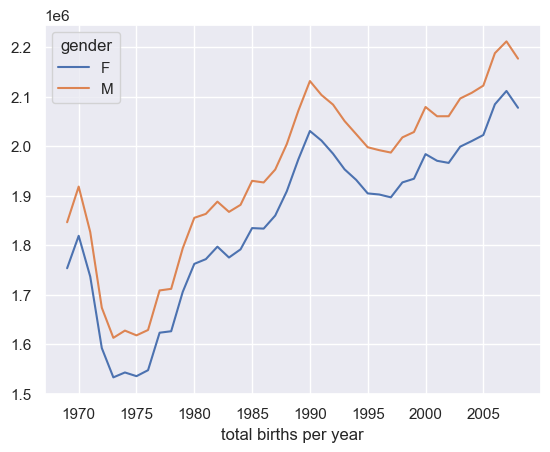

In [102]:
%matplotlib inline

import matplotlib.pyplot as plt
sns.set()  # use Seaborn styles
births.pivot_table('births', index='year', columns='gender', aggfunc='sum').plot()
plt.xlabel('total births per year')

Con una simple tabla dinámica y el método ``plot()``, podemos ver inmediatamente la tendencia anual de los nacimientos por género. A ojo, parece que en los últimos 50 años los nacimientos masculinos han superado a los femeninos en aproximadamente un 5%.